In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import time 

from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
class NeuralNetwork:
    
    def __init__(self,n_samples,layers,l_rate,reg_lambda,batch_size):
        
        self.m = batch_size                        # m is number of samples in the dataset
        self.n = n_samples                        # n in number of independent features
        
        self.l_rate = l_rate                       # learning rate 
        self.reg_lambda = reg_lambda               # regularization parameter
        
        # Initializing weights for hidden layers
        self.W1 = np.random.rand(layers[0],self.n)
        self.b1 = np.random.rand(1,layers[0])
        
        self.W2 = np.random.rand(layers[1],layers[0])
        self.b2 = np.random.rand(1,layers[1])
        
        self.W3 = np.random.rand(layers[2],layers[1])
        self.b3 = np.random.rand(1,layers[2])
        
        self.model = {'epoch':[],'W1':[],'b1':[],'W2':[],'b2':[],'W3':[],'b3':[]}
    
    def update_model(self,epoch):
        
        self.model['epoch'].append(epoch)
        self.model['W1'].append(self.W1)
        self.model['b1'].append(self.b1)
        self.model['W2'].append(self.W2)
        self.model['b2'].append(self.b2)
        self.model['W3'].append(self.W3)
        self.model['b3'].append(self.b3)
        
    def tanh_derivative(self,a):
        
        return 1-np.power(a,2)
    
    def train(self,X,y):
        
        self.X = X
        self.y = y
        
        # forward propagation
        self.Z1 = np.dot(self.X,self.W1.T)+self.b1
        self.A1 = np.tanh(self.Z1)
        
        assert(self.Z1.shape == self.A1.shape),'Z1 and A1 shapes not equal'
        
        self.Z2 = np.dot(self.A1,self.W2.T)+self.b2
        self.A2 =  np.tanh(self.Z2)
        
        assert(self.Z2.shape == self.A2.shape),'Z2 and A2 shapes not equal'
        
        self.Z3 = np.dot(self.A2,self.W3.T)+self.b3
        self.y_hat = softmax(self.Z3,axis=1)
        
        
        # backward propagation
        self.y = self.y.reshape(self.y_hat.shape) # reshaping y into y_hat's shape to avoid wrong calculations 
        
        #layer 3
        self.dZ3 = self.y_hat - self.y 
        
        self.dW3 = (1/self.m) * np.dot(self.dZ3.T,self.A2)
        
        self.db3 = (1/self.m) * np.sum(self.dZ3,axis=0,keepdims=True)
        
        assert self.dW3.shape == self.W3.shape
        assert self.db3.shape == self.b3.shape

        #layer 2
        self.dZ2 = np.multiply( np.dot(self.dZ3,self.W3) , self.tanh_derivative(self.A2) )
        
        assert self.dZ2.shape == self.A2.shape,"dZ2 and A2 shapes not equal"
        
        self.dW2 = (1/self.m) * np.dot(self.dZ2.T,self.A1)
        
        self.db2 = (1/self.m) * np.sum(self.dZ2,axis=0,keepdims=True)
        
        assert self.dW2.shape == self.W2.shape
        assert self.db2.shape == self.b2.shape
        
        #layer 1
        
        self.dZ1 = np.multiply( np.dot(self.dZ2,self.W2) , self.tanh_derivative(self.A1) )
        
        self.dW1 = (1/self.m) * np.dot(self.dZ1.T,self.X)
        
        self.db1 = (1/self.m) * np.sum(self.dZ1,axis=0,keepdims=True)
        
        self.dW3 = self.dW3 + self.reg_lambda * self.dW3   # regularizing to reduce overfitting 
        self.db3 = self.db3 + self.reg_lambda * self.db3
        self.dW2 = self.dW2 + self.reg_lambda * self.dW2   # regularizing to reduce overfitting 
        self.db2 = self.db2 + self.reg_lambda * self.db2
        self.dW1 = self.dW1 + self.reg_lambda * self.dW1        
        self.db2 = self.db2 + self.reg_lambda * self.db2
        
        self.W3 = self.W3 - self.l_rate * self.dW3 # updating weights
        self.b3 = self.b3 - self.l_rate * self.db3 # updating bias
        self.W2 = self.W2 - self.l_rate * self.dW2 # updating weights
        self.b2 = self.b2 - self.l_rate * self.db2 # updating bias
        self.W1 = self.W1 - self.l_rate * self.dW1 # updating weights
        self.b1 = self.b1 - self.l_rate * self.db1 # updating bias
        
    def cost(self):

        return (-1/self.m) * np.sum ((np.multiply(np.log(self.y_hat),self.y)))
    
    def predict(self,x):
        
        Z1 = np.dot(x,self.W1.T) + self.b1 
        
        A1 = np.tanh(Z1)
        
        Z2 = np.dot(A1,self.W2.T) + self.b2
        
        A2 = np.tanh(Z2)
        
        Z3 = np.dot(A2,self.W3.T) + self.b3
        
        y_hat = softmax(Z3)  

        preds = np.argmax(y_hat,axis=1)

        return preds
        

In [4]:
train = pd.read_csv('C:/Users/Srujan/Documents/Datasets/fashion-mnist_train.csv')
X = train.iloc[:,1:]
y = train.iloc[:,0]

In [5]:
X = np.array(X)
y = np.array(y).reshape(-1,1)

In [6]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [7]:
onehot = OneHotEncoder(sparse=False)
y_transformed_train = onehot.fit_transform(y_train)
y_transformed_test = onehot.transform(y_test)

In [8]:
y_transformed_train.shape

(42000, 10)

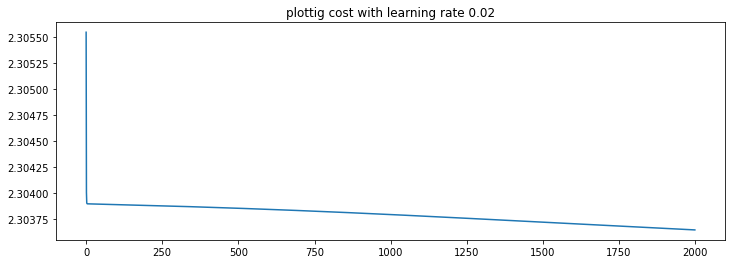

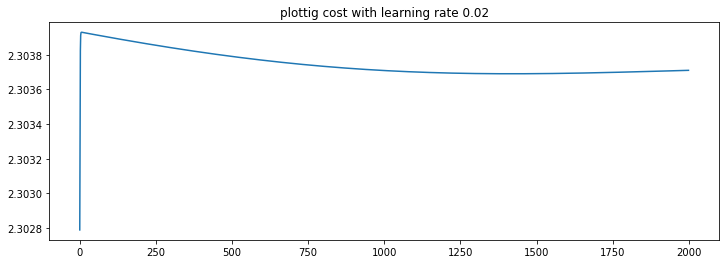

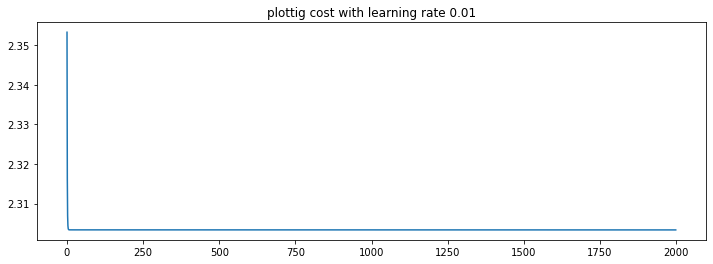

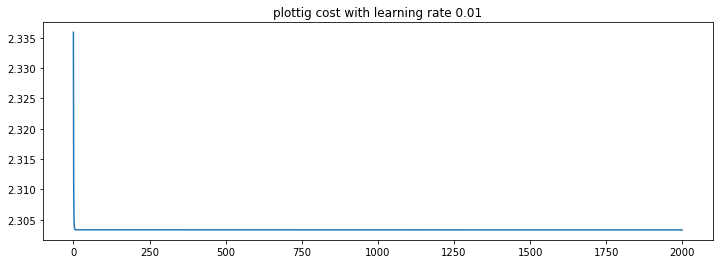

In [10]:
learning_rates = [0.02,0.01]
n_classes = y_transformed_train.shape[1]
n_samples = X_train.shape[1]
metrics = {'learning_rate':[],'nodes':[],'reg_param':[],'batch_size':[],'train_accuracy':[],'test_accuracy':[]}

for lr in learning_rates: # tuning learning rate
    
    # tuning nodes in hidden layers
    for nodes in [[2,3,n_classes]]:
        
        for reg_param in [0.003,0.005]: # tuning regularization parameter
            
            for batch_size in [128]: # tuning batch size
                cost_list = []
                n = NeuralNetwork(n_samples,nodes,lr,reg_param,batch_size)
                
                for epoch in range(0,2000):
                    start = 0                                                #batch starting index
                    end = batch_size
                    while (end <= X_train.shape[0]):

                        x_trainable = X_train[start:end,:]                    
                        y_trainable = y_transformed_train[start:end,:]
                        n.train(x_trainable,y_trainable)                     # batch size training
                        start = start+batch_size
                        end = end+batch_size                                 # updating indexes of batch size 
                   
                    cost_list.append(n.cost())
                    n.update_model(epoch)   
                    
                plt.figure(figsize=(12,4)) # plotting cost for every learning rate
                x_vals = list(range(2000))
                sns.lineplot(x=x_vals,y=cost_list)
                plt.title(f'plottig cost with learning rate {lr}')  
                
                y_train_preds = n.predict(X_train)  # converting output of sigmoid into predictions
                y_test_preds = n.predict(X_test)

                train_accuracy = accuracy_score(y_train,y_train_preds)
                test_accuracy = accuracy_score(y_test,y_test_preds)
                
                # adding to dictionary
                metrics['learning_rate'].append(lr)
                metrics['nodes'].append(nodes)
                metrics['reg_param'].append(reg_param)
                metrics['batch_size'].append(batch_size)
                metrics['train_accuracy'].append(train_accuracy)
                metrics['test_accuracy'].append(test_accuracy)                

In [11]:
metrics = pd.DataFrame(metrics)
metrics

,learning_rate,nodes,reg_param,batch_size,train_accuracy,test_accuracy
0,0.02,"[2, 3, 10]",0.003,128,0.1,0.1
1,0.02,"[2, 3, 10]",0.005,128,0.1,0.1
2,0.01,"[2, 3, 10]",0.003,128,0.1,0.1
3,0.01,"[2, 3, 10]",0.005,128,0.1,0.1


# Tuning only learning rate

In [12]:
%%time
learning_rates = [0.01,0.003,0.005,0.001,0.0005]
n_classes = y_transformed_train.shape[1]
n_samples = X_train.shape[1]

batch_size=64
metrics = {'learning_rate':[],'train_accuracy':[],'test_accuracy':[]}

for lr in learning_rates: 
    
    n = NeuralNetwork(n_samples,[3,3,n_classes],lr,0.003,batch_size)

    for epoch in range(0,500):
        start = 0                                                #batch starting index
        end = batch_size
        while (end <= X_train.shape[0]):

            x_trainable = X_train[start:end,:]                    
            y_trainable = y_transformed_train[start:end,:]
            n.train(x_trainable,y_trainable)                     # batch size training
            start = start+batch_size
            end = end+batch_size                                 # updating indexes of batch size 

        n.update_model(epoch)   

    y_train_preds = n.predict(X_train)  # converting output of sigmoid into predictions
    y_test_preds = n.predict(X_test)

    train_accuracy = accuracy_score(y_train,y_train_preds)
    test_accuracy = accuracy_score(y_test,y_test_preds)
    #adding to dictionary
    metrics['learning_rate'].append(lr)
    metrics['train_accuracy'].append(train_accuracy)
    metrics['test_accuracy'].append(test_accuracy)   

dict_items([('learning_rate', [0.01]), ('train_accuracy', [0.1]), ('test_accuracy', [0.1])])
dict_items([('learning_rate', [0.01, 0.003]), ('train_accuracy', [0.1, 0.1]), ('test_accuracy', [0.1, 0.1])])
dict_items([('learning_rate', [0.01, 0.003, 0.005]), ('train_accuracy', [0.1, 0.1, 0.1]), ('test_accuracy', [0.1, 0.1, 0.1])])
dict_items([('learning_rate', [0.01, 0.003, 0.005, 0.001]), ('train_accuracy', [0.1, 0.1, 0.1, 0.1]), ('test_accuracy', [0.1, 0.1, 0.1, 0.1])])
dict_items([('learning_rate', [0.01, 0.003, 0.005, 0.001, 0.0005]), ('train_accuracy', [0.1, 0.1, 0.1, 0.1, 0.1]), ('test_accuracy', [0.1, 0.1, 0.1, 0.1, 0.1])])
Wall time: 22min 40s


# Fixed params

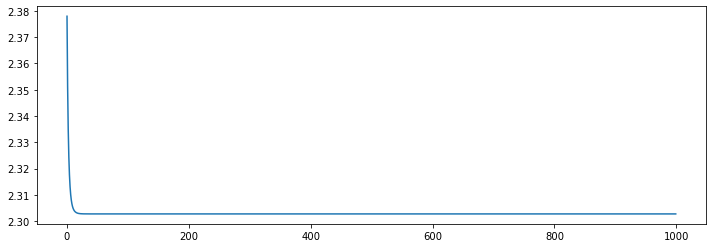

In [21]:
n_classes = y_transformed_train.shape[1]
n_samples = X_train.shape[1]
batch_size=128

n = NeuralNetwork(n_samples,[3,3,n_classes],0.002,0.003,batch_size)
cost_list = []

for epoch in range(0,1000):
    start = 0                                                #batch starting index
    end = batch_size
    while (end <= X_train.shape[0]):

        x_trainable = X_train[start:end,:]                    
        y_trainable = y_transformed_train[start:end,:]
        n.train(x_trainable,y_trainable)                     # batch size training
        start = start+batch_size
        end = end+batch_size                                 # updating indexes of batch size 
    
    cost_list.append(n.cost())
    n.update_model(epoch)   
    
plt.figure(figsize=(12,4)) # plotting cost for every learning rate
x_vals = list(range(1000))
sns.lineplot(x=x_vals,y=cost_list)

y_train_preds = n.predict(X_train)  # converting output of sigmoid into predictions
y_test_preds = n.predict(X_test)

train_accuracy = accuracy_score(y_train,y_train_preds)
test_accuracy = accuracy_score(y_test,y_test_preds)